In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

from utils import clean_data
from utils import split_trajectories
from utils import replicate_initial_position_by_block
from utils import get_n_trajectories
from utils import plot_y_yhat
from utils import add_three_body_features

In [2]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [3]:
train_cleaned=clean_data(train)

In [24]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [26]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [31]:
velocity_cols = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

train_cleaned_no_velocity = train_cleaned.drop(columns=['Id'] + velocity_cols, errors='ignore')

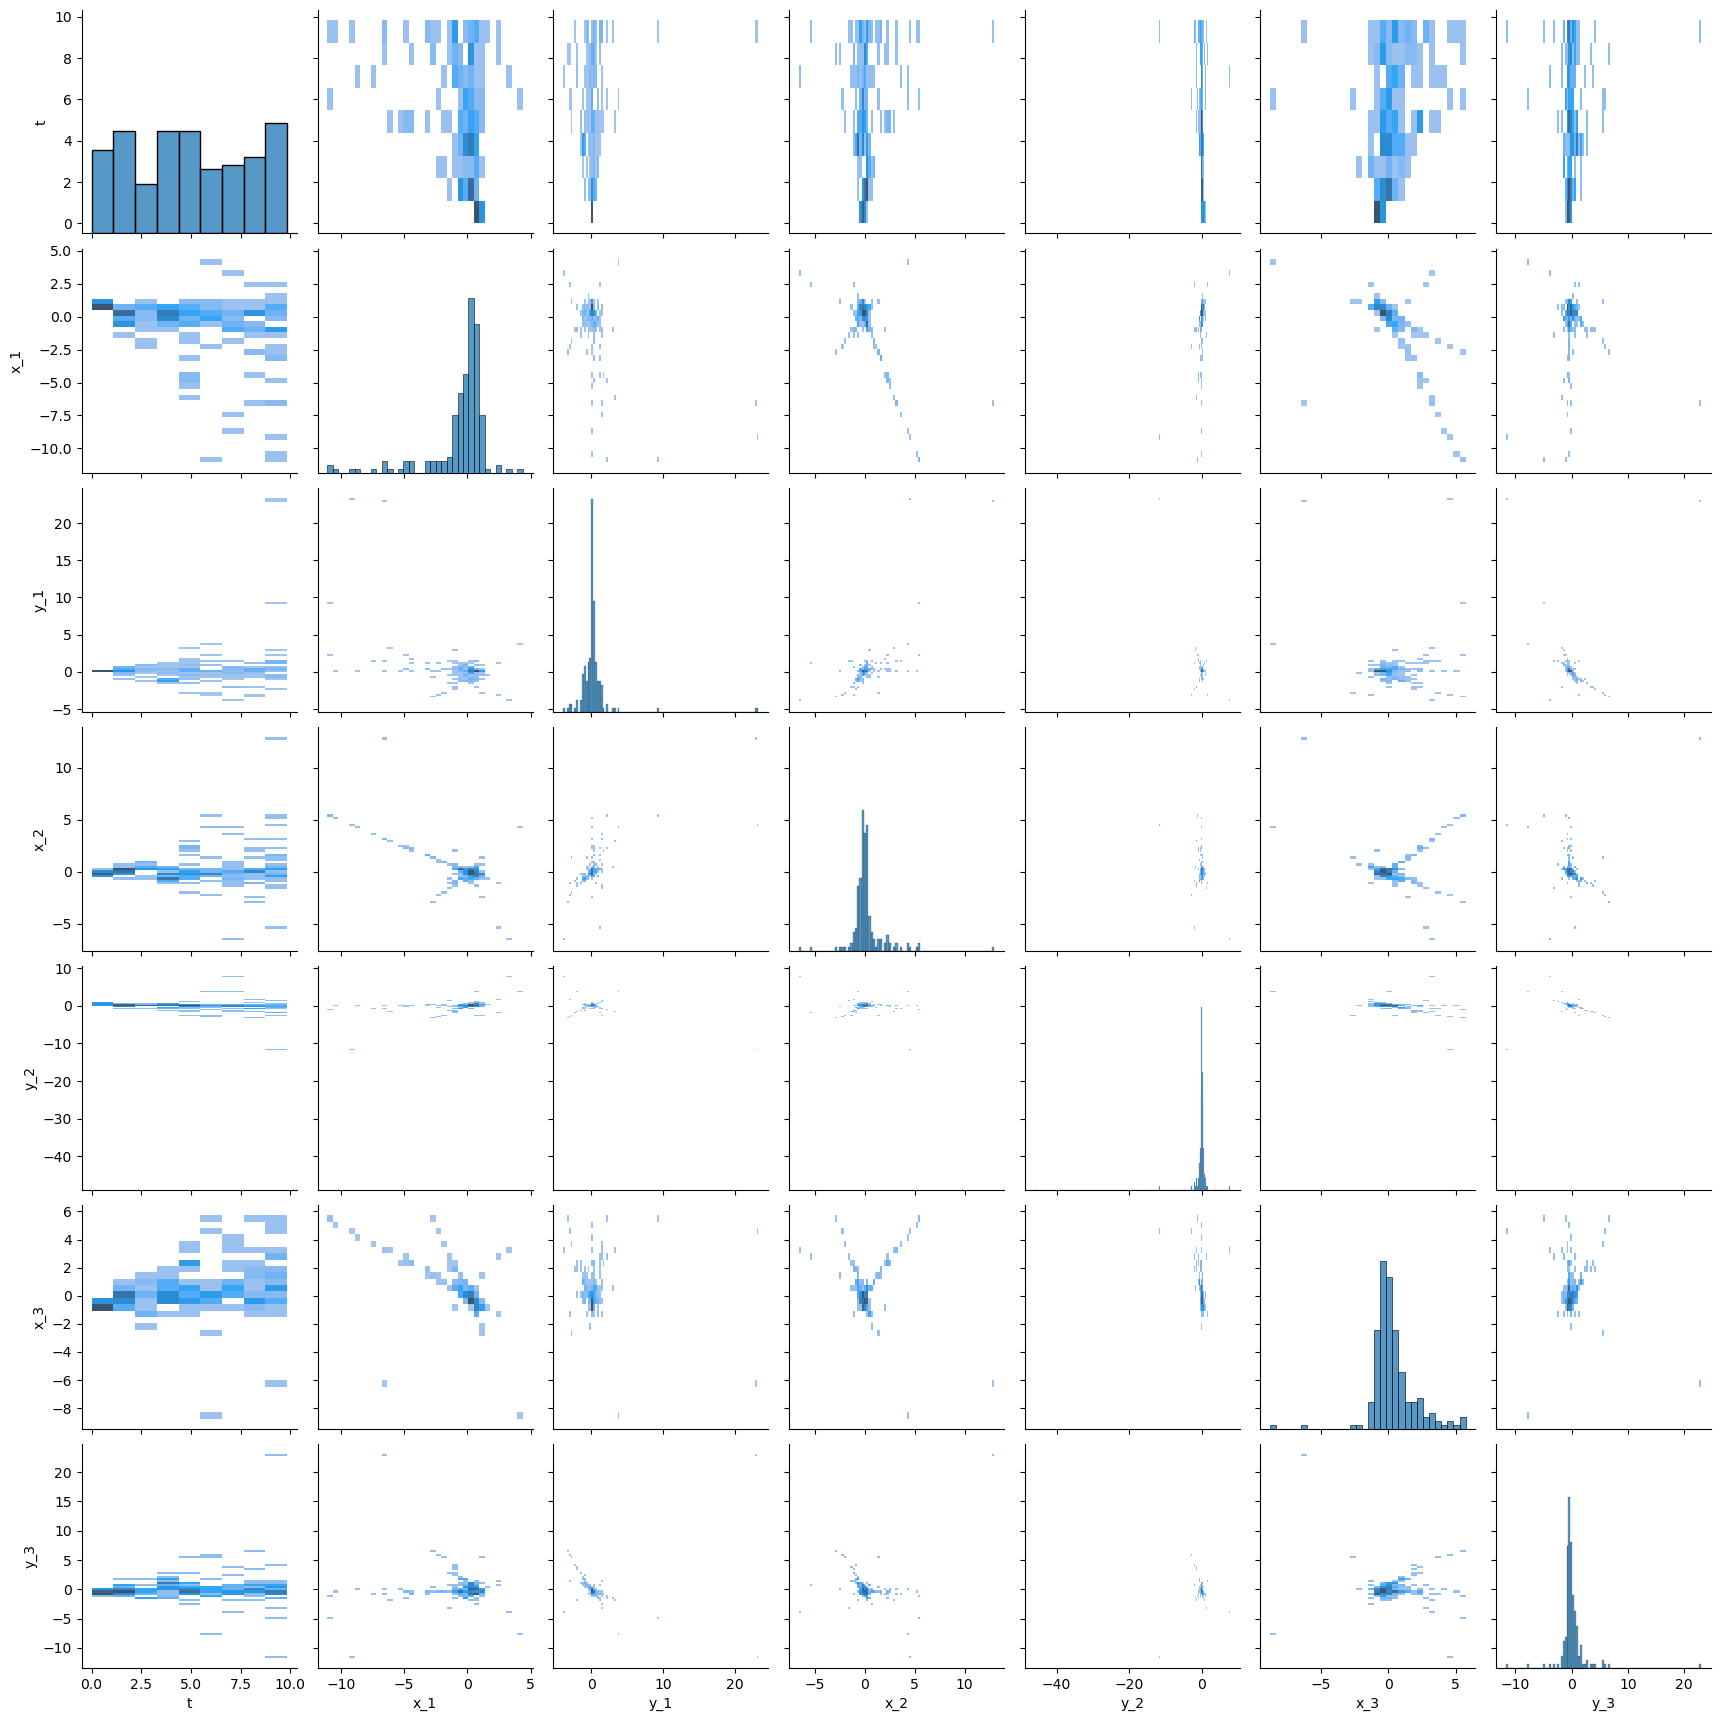

In [32]:
sns.pairplot(train_cleaned_no_velocity.sample(200), kind="hist")

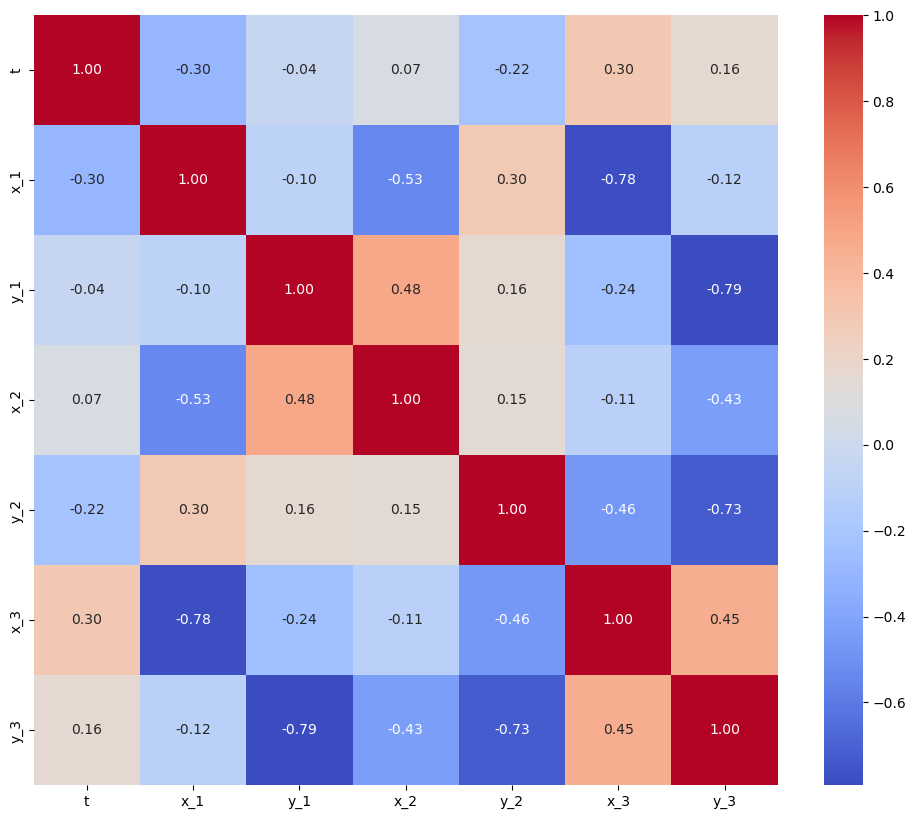

In [33]:
corr = train_cleaned_no_velocity.corr()

plt.figure(figsize=(12,10))  # tu peux ajuster largeur et hauteur
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

In [34]:
corr_long = corr.abs().stack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'AbsCorr']
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]
corr_long = corr_long.drop_duplicates(subset=['AbsCorr'])
corr_long_sorted = corr_long.sort_values(by='AbsCorr', ascending=False)
corr_long_sorted

,Feature1,Feature2,AbsCorr
20,y_1,y_3,0.792859
12,x_1,x_3,0.780996
34,y_2,y_3,0.728556
10,x_1,x_2,0.534279
17,y_1,x_2,0.484456
33,y_2,x_3,0.464365
41,x_3,y_3,0.453896
27,x_2,y_3,0.430117
5,t,x_3,0.302133
11,x_1,y_2,0.299352


In [10]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Baseline RMSE: 1.2718931013524308
Removed y_3, RMSE = 1.2719
Removed x_3, RMSE = 1.2719
Removed x_2, RMSE = 1.3038
Removed y_2, RMSE = 1.3343
Removed x_1, RMSE = 1.3343
Removed y_1, RMSE = 1.3343
Features finally removed: ['y_3', 'x_3', 'x_2', 'y_2', 'x_1', 'y_1']


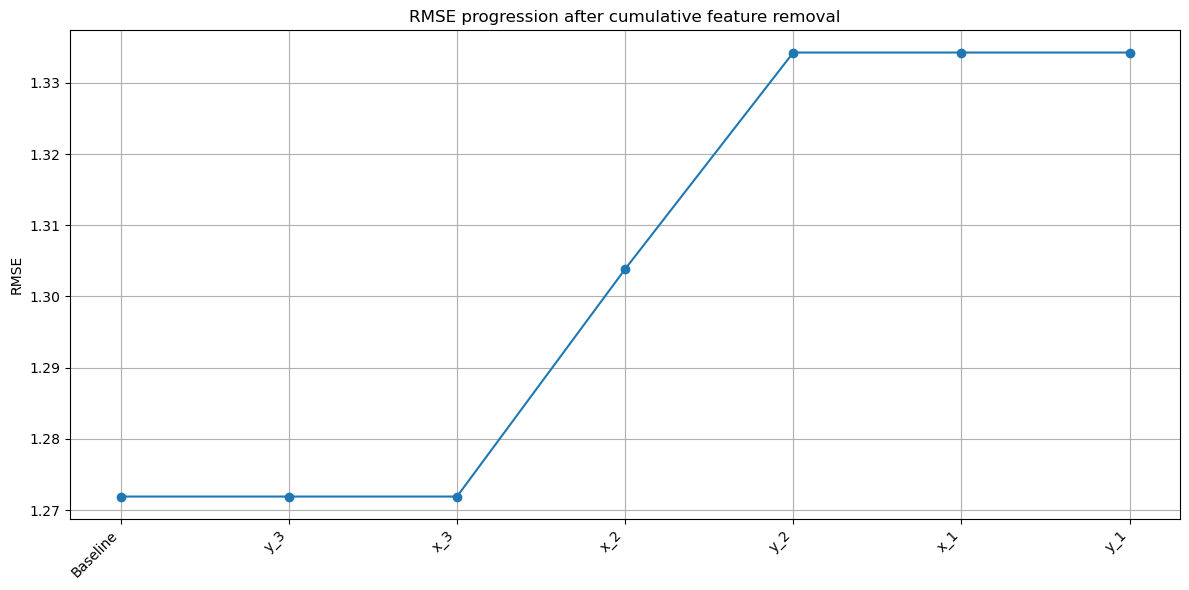

In [11]:
# Colonnes d'entrée dans l'ordre souhaité
input_cols = [
    't',
    'x_1', 'y_1',
    'x_2', 'y_2',
    'x_3', 'y_3'
]

# Colonnes cibles : positions uniquement
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

# Préparer les datasets d'entraînement
X_train = train_entry[input_cols].copy()          
y_train = train_after_split[target_cols].copy()

# Préparer les datasets de validation
X_val = validation_entry[input_cols].copy()
y_val = validation_after_split[target_cols].copy()


# 2. Fonction pour tester l'impact de la suppression d'une variable sur RMSE
def test_feature_removal(pipeline, X_train, y_train, X_val, y_val, feature_to_remove):
    X_train_mod = X_train.drop(columns=[feature_to_remove])
    X_val_mod = X_val.drop(columns=[feature_to_remove])
    
    pipeline.fit(X_train_mod, y_train)
    y_pred = pipeline.predict(X_val_mod)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

    
# Copier les datasets pour suppression cumulative
X_train_temp = X_train.copy()
X_val_temp = X_val.copy()

removed_features = []

# Baseline RMSE avec toutes les features
pipeline.fit(X_train_temp, y_train)
y_pred_base = pipeline.predict(X_val_temp)
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_pred_base))
print("Baseline RMSE:", baseline_rmse)

# Liste pour stocker l'évolution du RMSE
rmse_list = [baseline_rmse]
features_list = ['Baseline']

# Boucle sur les paires de features triées par corrélation décroissante
for _, row in corr_long_sorted.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    
    # Supprimer la deuxième feature de la paire si elle n'a pas déjà été supprimée
    if f2 not in removed_features:
        X_train_temp.drop(columns=[f2], inplace=True, errors='ignore')
        X_val_temp.drop(columns=[f2], inplace=True, errors='ignore')
        
        # Calculer le RMSE avec le dataset réduit
        pipeline.fit(X_train_temp, y_train)
        y_pred = pipeline.predict(X_val_temp)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f"Removed {f2}, RMSE = {rmse:.4f}")
        
        # Stocker pour graphique
        removed_features.append(f2)
        rmse_list.append(rmse)
        features_list.append(f2)

print("Features finally removed:", removed_features)

# --- Graphique RMSE vs Features supprimées ---
plt.figure(figsize=(12,6))
plt.plot(rmse_list, marker='o')
plt.xticks(range(len(features_list)), features_list, rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("RMSE progression after cumulative feature removal")
plt.grid(True)
plt.tight_layout()
plt.show()

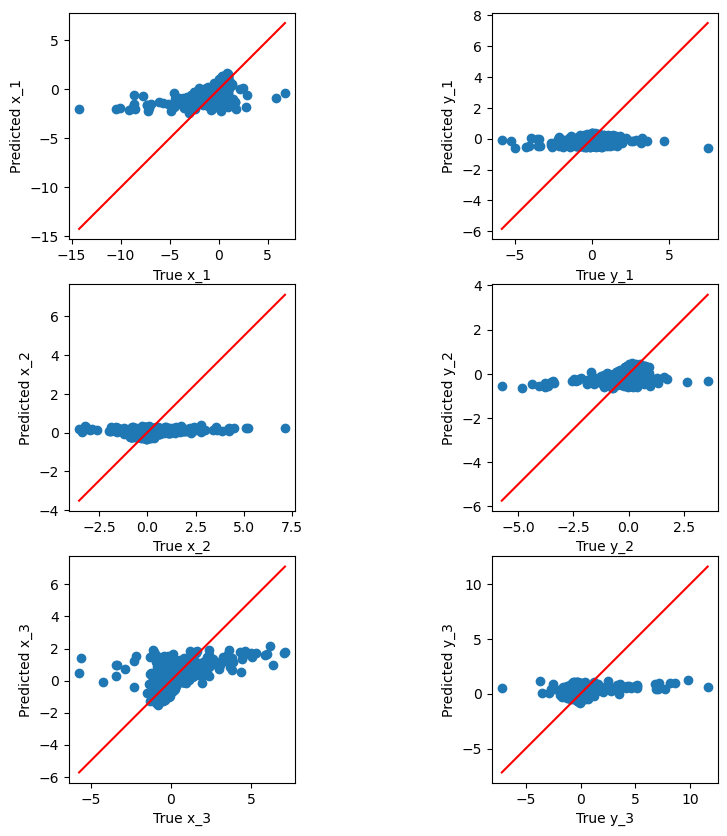

In [12]:
pipeline2 = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2']#without x3 y3
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline2.fit(X_train, y_train)
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline2.predict(X_val) 

plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")

In [6]:
import itertools

# --- Paramètres ---
N_ESSAIS = 5  # nombre de splits différents

# --- Définition des groupes de variables ---
groupes = {
    0: ['t', 'x_1', 'y_1', 'x_2', 'y_2'],  # toujours présents
    1: ['r_12', 'r_13', 'r_23'],
    2: ['inv_r_12', 'inv_r_13', 'inv_r_23'],
    3: ['r12_over_r13', 'r12_over_r23', 'r13_over_r23'],
    4: ['triangle_area'],
    5: ['d1_cm', 'd2_cm', 'd3_cm']
}
groupes_optionnels = [1, 2, 3, 4, 5]

# --- Génération de toutes les combinaisons possibles ---
combinaisons = []
for r in range(0, len(groupes_optionnels) + 1):
    for subset in itertools.combinations(groupes_optionnels, r):
        combinaisons.append((0,) + subset)  # toujours inclure le groupe 0

# --- Définition du modèle ---
pipeline = make_pipeline(StandardScaler(), LinearRegression())

# --- Colonnes cibles ---
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

# --- Stockage des résultats cumulés ---
resultats_cumul = {combo: [] for combo in combinaisons}

# --- Boucle sur N essais ---
for essai in range(N_ESSAIS):
    # Split et enrichissement à chaque essai
    train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)
    train_entry = replicate_initial_position_by_block(train_after_split)
    validation_entry = replicate_initial_position_by_block(validation_after_split)
    test_entry = replicate_initial_position_by_block(test_after_split)
    
    X_train_enriched = add_three_body_features(train_entry)
    X_val_enriched   = add_three_body_features(validation_entry)
    
    # Boucle sur toutes les combinaisons
    for combo in combinaisons:
        features = [col for g in combo for col in groupes[g]]
        
        X_train = X_train_enriched[features]
        y_train = train_after_split[target_cols]
        X_val = X_val_enriched[features]
        y_val = validation_after_split[target_cols]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        rmse_global = np.sqrt(mean_squared_error(y_val, y_pred))
        
        # Stockage du RMSE global pour cette combinaison et cet essai
        resultats_cumul[combo].append(rmse_global)

# --- Calcul de la moyenne sur N essais ---
resultats_moyens = []
for combo, rmses in resultats_cumul.items():
    resultats_moyens.append({
        'combinaison': combo,
        'RMSE_global_mean': np.mean(rmses)
    })

df_resultats = pd.DataFrame(resultats_moyens).sort_values(by='RMSE_global_mean', ascending=True)

# RMSE de la combinaison de base (0)
rmse_base = df_resultats[df_resultats['combinaison'] == (0,)]['RMSE_global_mean'].values[0]

print("Top 5 best feature combinations over 10 runs (average RMSE)")
print(df_resultats[['combinaison', 'RMSE_global_mean']].head(5).to_string(index=False))
print(f"\nRMSE of the base combination (0): {rmse_base:.4f}")


Top 5 best feature combinations over 10 runs (average RMSE)
       combinaison  RMSE_global_mean
   (0, 1, 2, 3, 5)          1.376043
(0, 1, 2, 3, 4, 5)          1.376043
      (0, 1, 3, 5)          1.381683
   (0, 1, 3, 4, 5)          1.381683
   (0, 1, 2, 3, 4)          1.384653

RMSE of the base combination (0): 1.4277


In [8]:

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(2,3), max_features=None):
    start_time = time.time()

    best_rmse = np.inf
    best_model = None
    best_degree = None
    best_alpha = None
    best_reg = None

    # Même grille de valeurs d'alpha pour L1 et L2
    alphas = np.logspace(-5, 5, 13)

    for degree in tqdm(degrees, desc="Testing degrees"):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly.fit(X_train)
        n_features = poly.n_output_features_
        print(f"Degree {degree}: {n_features} features")

        if max_features and n_features > max_features:
            print(f" Skipped degree {degree} (too many features: {n_features})")
            continue

        if regressor == 'L2':
            # RidgeCV avec la grille d'alphas partagée
            model = RidgeCV(
                alphas=alphas,
                scoring='neg_mean_squared_error',
                cv=5
            )
            pipe = Pipeline([
                ('poly', poly),
                ('scaler', StandardScaler()),
                ('reg', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            best_alpha_current = pipe['reg'].alpha_

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = best_alpha_current
                best_reg = 'L2'

        elif regressor == 'L1':
            # LassoCV avec la même grille d'alphas
            model = MultiTaskLassoCV(
                alphas=alphas,
                cv=5
            )
            pipe = Pipeline([
                ('poly', poly),
                ('scaler', StandardScaler()),
                ('reg', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            best_alpha_current = pipe['reg'].alpha_

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = best_alpha_current
                best_reg = 'L1'

        else:
            # Régression linéaire simple
            model = LinearRegression()
            pipe = Pipeline([
                ('poly', poly),
                ('scaler', StandardScaler()),
                ('reg', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = None
                best_reg = 'None'

    elapsed_time = time.time() - start_time
    print(f"\n⏱️ Total elapsed time: {elapsed_time:.2f} seconds")
    print(f"✅ Best model: degree={best_degree}, RMSE={best_rmse:.4f}, reg={best_reg}, alpha={best_alpha}")

    return best_model, best_rmse, best_degree, best_reg, best_alpha

In [17]:
#best_model_L1, best_rmse_L1, best_degree_L1, best_reg_L1, best_alpha_L1 = validate_poly_regression(
#   X_train, y_train,X_val,y_val, regressor='L1'
#)

best_model_L2, best_rmse_L2, best_degree_L2, best_reg_L2, best_alpha_L2 = validate_poly_regression(
   X_train, y_train,X_val,y_val, regressor='L2'
)

#best_model_L, best_rmse_L, best_degree_L, best_reg_L, best_alpha_L = validate_poly_regression(
#   X_train, y_train,X_val,y_val
#)

Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 20 features


Testing degrees: 100%|██████████| 1/1 [00:28<00:00, 28.43s/it]


⏱️ Total elapsed time: 28.44 seconds
✅ Best model: degree=2, RMSE=1.2934, reg=L2, alpha=2154.4346900318865


RMSE validation: 1.267824847890643


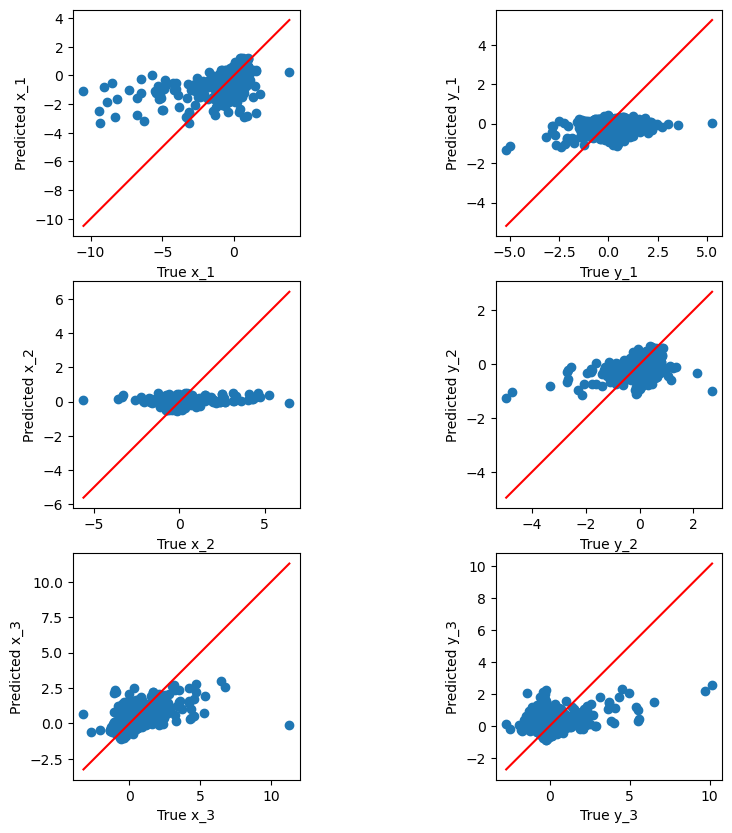

In [19]:
y_pred_val = best_model_L2.predict(X_val) 

rmse_validation = root_mean_squared_error(y_val,y_pred_val)
print("RMSE validation:", rmse_validation)

plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")

In [27]:
X_train_enriched = add_three_body_features(train_entry)
X_val_enriched   = add_three_body_features(validation_entry)
X_test_enriched   = add_three_body_features(test_entry)

In [21]:
# Variables à considérer (tous les groupes)
all_features = [
    't', 'x_1', 'y_1', 'x_2', 'y_2',
    'r_12', 'r_13', 'r_23',
    'inv_r_12', 'inv_r_13', 'inv_r_23',
    'r12_over_r13', 'r12_over_r23', 'r13_over_r23',
    'triangle_area',
    'd1_cm', 'd2_cm', 'd3_cm'
]

# Extraire les colonnes d'intérêt
X_sel = X_train_enriched[all_features].copy()

# Calcul de la matrice de corrélation
corr_matrix = X_sel.corr()

# Mettre sous forme de paires
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Supprimer doublons et diagonale
corr_pairs = corr_pairs[corr_pairs['Feature_1'] < corr_pairs['Feature_2']]

# Garder uniquement les corrélations fortes (|corr| > 0.70)
strong_corr = corr_pairs[abs(corr_pairs['Correlation']) > 0.70].sort_values(by='Correlation', ascending=False)

# Compter combien
nb_strong = strong_corr.shape[0]

print(f"📊 Nombre de paires de variables fortement corrélées (|corr| > 0.70) : {nb_strong}")
display(strong_corr)

📊 Nombre de paires de variables fortement corrélées (|corr| > 0.70) : 40


,Feature_1,Feature_2,Correlation
256,triangle_area,y_2,1.000000
193,inv_r_23,r13_over_r23,0.990486
192,inv_r_23,r12_over_r23,0.971698
302,d2_cm,triangle_area,0.962608
292,d2_cm,y_2,0.962608
130,r_23,y_2,0.934265
140,r_23,triangle_area,0.934265
229,r12_over_r23,r13_over_r23,0.931031
312,d3_cm,r_13,0.917491
313,d3_cm,r_23,0.910497


In [22]:
import itertools

# -------------------------------
# Groupes de features
# -------------------------------
groupes = {
    0: ['t', 'x_1', 'y_1', 'x_2', 'y_2'],  # toujours présents
    1: ['r_12', 'r_13', 'r_23'],
    2: ['inv_r_12', 'inv_r_13', 'inv_r_23'],
    3: ['r12_over_r13', 'r12_over_r23', 'r13_over_r23'],
    4: ['triangle_area'],
    5: ['d1_cm', 'd2_cm', 'd3_cm']
}

groupes_optionnels = [1, 2, 3, 4, 5]

# -------------------------------
# Toutes les combinaisons de groupes
# -------------------------------
combinaisons = []
for r in range(0, len(groupes_optionnels) + 1):
    for subset in itertools.combinations(groupes_optionnels, r):
        combinaison_complete = (0,) + subset  # toujours inclure le groupe 0
        combinaisons.append(combinaison_complete)

print(f"Nombre total de combinaisons testées : {len(combinaisons)}")

# -------------------------------
# Targets
# -------------------------------
target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
y_train = train_after_split[target_cols].copy()
y_val   = validation_after_split[target_cols].copy()

# -------------------------------
# Tester toutes les combinaisons
# -------------------------------
results_poly = []

for combo in combinaisons:
    # Construire la liste des features à utiliser
    features = groupes[0].copy()
    for g in combo:
        features += groupes[g]

    # Sélection des features
    X_train_sel = X_train_enriched[features]
    X_val_sel   = X_val_enriched[features]

    # Valider le modèle polynomiale L2
    best_model, best_rmse, best_degree, best_reg, best_alpha = validate_poly_regression(
        X_train_sel, y_train, X_val_sel, y_val, regressor='L2'
    )

    # Stocker le résultat
    results_poly.append({
        'groups': combo,
        'features': features,
        'rmse': best_rmse,
        'degree': best_degree,
        'reg': best_reg,
        'alpha': best_alpha
    })

    # Afficher le résultat pour cette combinaison
    print(f"Groups {combo} | RMSE: {best_rmse:.5f} | Degree: {best_degree} | Alpha: {best_alpha} | Features: {features}")

# -------------------------------
# Trouver le meilleur modèle
# -------------------------------
best_result = min(results_poly, key=lambda x: x['rmse'])
print("\n✅ Best Polynomial L2 Model:")
print(f"Groups: {best_result['groups']}")
print(f"RMSE: {best_result['rmse']:.5f}")
print(f"Degree: {best_result['degree']}, Alpha: {best_result['alpha']}")
print(f"Features used: {best_result['features']}")


Nombre total de combinaisons testées : 32


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 65 features


Testing degrees: 100%|██████████| 1/1 [00:47<00:00, 47.95s/it]



⏱️ Total elapsed time: 47.96 seconds
✅ Best model: degree=2, RMSE=1.2934, reg=L2, alpha=2154.4346900318865
Groups (0,) | RMSE: 1.29339 | Degree: 2 | Alpha: 2154.4346900318865 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 104 features


Testing degrees: 100%|██████████| 1/1 [01:25<00:00, 85.23s/it]



⏱️ Total elapsed time: 85.25 seconds
✅ Best model: degree=2, RMSE=1.2146, reg=L2, alpha=1e-05
Groups (0, 1) | RMSE: 1.21455 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 104 features


Testing degrees: 100%|██████████| 1/1 [01:07<00:00, 67.22s/it]



⏱️ Total elapsed time: 67.23 seconds
✅ Best model: degree=2, RMSE=1.2200, reg=L2, alpha=0.021544346900318846
Groups (0, 2) | RMSE: 1.21995 | Degree: 2 | Alpha: 0.021544346900318846 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'inv_r_12', 'inv_r_13', 'inv_r_23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 104 features


Testing degrees: 100%|██████████| 1/1 [01:06<00:00, 66.84s/it]



⏱️ Total elapsed time: 66.84 seconds
✅ Best model: degree=2, RMSE=1.2413, reg=L2, alpha=0.14677992676220705
Groups (0, 3) | RMSE: 1.24134 | Degree: 2 | Alpha: 0.14677992676220705 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 77 features


Testing degrees: 100%|██████████| 1/1 [01:11<00:00, 71.24s/it]



⏱️ Total elapsed time: 71.25 seconds
✅ Best model: degree=2, RMSE=1.2934, reg=L2, alpha=2154.4346900318865
Groups (0, 4) | RMSE: 1.29339 | Degree: 2 | Alpha: 2154.4346900318865 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'triangle_area']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 104 features


Testing degrees: 100%|██████████| 1/1 [01:13<00:00, 73.54s/it]



⏱️ Total elapsed time: 73.55 seconds
✅ Best model: degree=2, RMSE=1.2486, reg=L2, alpha=0.021544346900318846
Groups (0, 5) | RMSE: 1.24860 | Degree: 2 | Alpha: 0.021544346900318846 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 152 features


Testing degrees: 100%|██████████| 1/1 [01:49<00:00, 109.33s/it]



⏱️ Total elapsed time: 109.34 seconds
✅ Best model: degree=2, RMSE=1.1857, reg=L2, alpha=1e-05
Groups (0, 1, 2) | RMSE: 1.18573 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'inv_r_12', 'inv_r_13', 'inv_r_23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 152 features


Testing degrees: 100%|██████████| 1/1 [02:00<00:00, 120.57s/it]



⏱️ Total elapsed time: 120.58 seconds
✅ Best model: degree=2, RMSE=1.1907, reg=L2, alpha=1e-05
Groups (0, 1, 3) | RMSE: 1.19072 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 119 features


Testing degrees: 100%|██████████| 1/1 [01:20<00:00, 80.64s/it]



⏱️ Total elapsed time: 80.65 seconds
✅ Best model: degree=2, RMSE=1.2146, reg=L2, alpha=1e-05
Groups (0, 1, 4) | RMSE: 1.21456 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'triangle_area']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 152 features


Testing degrees: 100%|██████████| 1/1 [02:27<00:00, 147.98s/it]



⏱️ Total elapsed time: 147.99 seconds
✅ Best model: degree=2, RMSE=1.1811, reg=L2, alpha=1e-05
Groups (0, 1, 5) | RMSE: 1.18111 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 152 features


Testing degrees: 100%|██████████| 1/1 [02:11<00:00, 131.29s/it]



⏱️ Total elapsed time: 131.30 seconds
✅ Best model: degree=2, RMSE=1.1952, reg=L2, alpha=1e-05
Groups (0, 2, 3) | RMSE: 1.19515 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'inv_r_12', 'inv_r_13', 'inv_r_23', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 119 features


Testing degrees: 100%|██████████| 1/1 [01:26<00:00, 86.68s/it]



⏱️ Total elapsed time: 86.68 seconds
✅ Best model: degree=2, RMSE=1.2199, reg=L2, alpha=0.021544346900318846
Groups (0, 2, 4) | RMSE: 1.21993 | Degree: 2 | Alpha: 0.021544346900318846 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'inv_r_12', 'inv_r_13', 'inv_r_23', 'triangle_area']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 152 features


Testing degrees: 100%|██████████| 1/1 [03:20<00:00, 200.13s/it]



⏱️ Total elapsed time: 200.14 seconds
✅ Best model: degree=2, RMSE=1.1900, reg=L2, alpha=1e-05
Groups (0, 2, 5) | RMSE: 1.18997 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'inv_r_12', 'inv_r_13', 'inv_r_23', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 119 features


Testing degrees: 100%|██████████| 1/1 [02:07<00:00, 127.54s/it]



⏱️ Total elapsed time: 127.55 seconds
✅ Best model: degree=2, RMSE=1.2396, reg=L2, alpha=0.021544346900318846
Groups (0, 3, 4) | RMSE: 1.23959 | Degree: 2 | Alpha: 0.021544346900318846 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23', 'triangle_area']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 152 features


Testing degrees: 100%|██████████| 1/1 [02:54<00:00, 174.62s/it]



⏱️ Total elapsed time: 174.63 seconds
✅ Best model: degree=2, RMSE=1.1999, reg=L2, alpha=0.0004641588833612782
Groups (0, 3, 5) | RMSE: 1.19985 | Degree: 2 | Alpha: 0.0004641588833612782 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 119 features


Testing degrees: 100%|██████████| 1/1 [02:07<00:00, 127.11s/it]



⏱️ Total elapsed time: 127.12 seconds
✅ Best model: degree=2, RMSE=1.2486, reg=L2, alpha=0.021544346900318846
Groups (0, 4, 5) | RMSE: 1.24859 | Degree: 2 | Alpha: 0.021544346900318846 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'triangle_area', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 209 features


Testing degrees: 100%|██████████| 1/1 [04:37<00:00, 277.05s/it]



⏱️ Total elapsed time: 277.06 seconds
✅ Best model: degree=2, RMSE=1.1736, reg=L2, alpha=1e-05
Groups (0, 1, 2, 3) | RMSE: 1.17365 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'inv_r_12', 'inv_r_13', 'inv_r_23', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 170 features


Testing degrees: 100%|██████████| 1/1 [02:45<00:00, 165.86s/it]



⏱️ Total elapsed time: 165.87 seconds
✅ Best model: degree=2, RMSE=1.1856, reg=L2, alpha=1e-05
Groups (0, 1, 2, 4) | RMSE: 1.18559 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'inv_r_12', 'inv_r_13', 'inv_r_23', 'triangle_area']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 209 features


Testing degrees: 100%|██████████| 1/1 [03:51<00:00, 231.24s/it]



⏱️ Total elapsed time: 231.25 seconds
✅ Best model: degree=2, RMSE=1.1703, reg=L2, alpha=1e-05
Groups (0, 1, 2, 5) | RMSE: 1.17035 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'inv_r_12', 'inv_r_13', 'inv_r_23', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 170 features


Testing degrees: 100%|██████████| 1/1 [02:28<00:00, 148.73s/it]



⏱️ Total elapsed time: 148.73 seconds
✅ Best model: degree=2, RMSE=1.1906, reg=L2, alpha=1e-05
Groups (0, 1, 3, 4) | RMSE: 1.19061 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23', 'triangle_area']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 209 features


Testing degrees: 100%|██████████| 1/1 [02:33<00:00, 153.87s/it]



⏱️ Total elapsed time: 153.88 seconds
✅ Best model: degree=2, RMSE=1.1725, reg=L2, alpha=1e-05
Groups (0, 1, 3, 5) | RMSE: 1.17254 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 170 features


Testing degrees: 100%|██████████| 1/1 [01:57<00:00, 117.58s/it]



⏱️ Total elapsed time: 117.59 seconds
✅ Best model: degree=2, RMSE=1.1811, reg=L2, alpha=1e-05
Groups (0, 1, 4, 5) | RMSE: 1.18107 | Degree: 2 | Alpha: 1e-05 | Features: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'triangle_area', 'd1_cm', 'd2_cm', 'd3_cm']


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 170 features


Testing degrees:   0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [28]:

groupes = {
    0: ['t', 'x_1', 'y_1', 'x_2', 'y_2'],  
    1: ['r_12', 'r_13', 'r_23'],
    3: ['r12_over_r13', 'r12_over_r23', 'r13_over_r23']
}

target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
y_train = train_after_split[target_cols].copy()
y_test   = test_after_split[target_cols].copy()

selected_groups = (0, 1, 3)
features = []
for g in selected_groups:
    features += groupes[g]

X_train_sel = X_train_enriched[features]
X_test_sel   = X_test_enriched[features]

polynomial_model, best_rmse, best_degree, best_reg, best_alpha = validate_poly_regression(
    X_train_sel, y_train, X_test_sel, y_test, regressor='L2'
)

print("\nPolynomial L2 Model with groups 0 + 1 + 3:")
print(f"RMSE: {best_rmse:.5f}")
print(f"Degree: {best_degree}, Alpha: {best_alpha}")
print(f"Features used: {features}")


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 77 features


Testing degrees: 100%|██████████| 1/1 [00:55<00:00, 55.03s/it]


⏱️ Total elapsed time: 55.04 seconds
✅ Best model: degree=2, RMSE=1.1825, reg=L2, alpha=1e-05

Polynomial L2 Model with groups 0 + 1 + 3:
RMSE: 1.18248
Degree: 2, Alpha: 1e-05
Features used: ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'r_12', 'r_13', 'r_23', 'r12_over_r13', 'r12_over_r23', 'r13_over_r23']


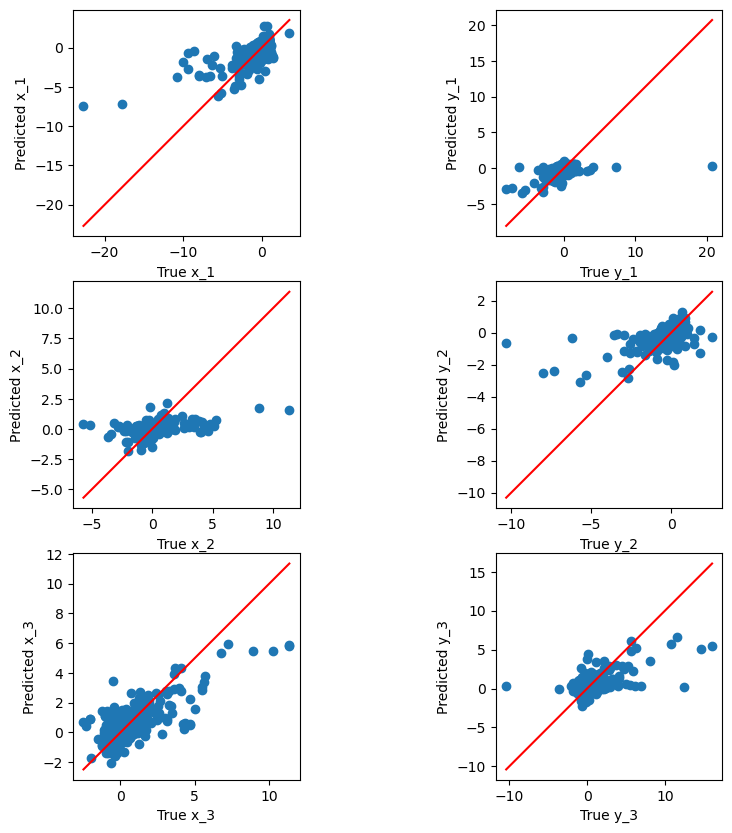

In [30]:
y_pred = polynomial_model.predict(X_test_sel)
plot_y_yhat(y_test.values, y_pred, plot_title="Polynomial L2 Model (groups 0 + 1 + 3)")


In [ ]:
X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3'] 


ids = test['Id']
X_test_augmented = add_three_body_features(X_test)

input_cols_augmented = [
    't', 'x_1', 'y_1', 'x_2', 'y_2',
    'r_12', 'r_13', 'r_23',
    #'inv_r_12', 'inv_r_13', 'inv_r_23',
    #'r12_over_r13', 'r12_over_r23', 'r13_over_r23',
    #'triangle_area',
    'd1_cm', 'd2_cm', 'd3_cm'
]

X_test_augmented = X_test_augmented[input_cols_augmented]

predictions = best_model_enriched.predict(X_test_augmented)

target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
output_df = pd.DataFrame(predictions, columns=target_cols)
output_df.insert(0, 'Id', ids)


output_df.to_csv('augmented_polynomial_submission.csv', index=False)